<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline_del_spon_podcast_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 799 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=c3b7df51354246a7e4d6a43d5b0845870dbf664a29ab7d2b03a060fbc34c0d35
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [3]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-04-30 22:22:14--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.04MB/s    in 15s     

2022-04-30 22:22:29 (2.04 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [4]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_podcast'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-04-30 22:22:31--  https://raw.githubusercontent.com/grace-boop/podcast/main/flora_podcast
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13074 (13K) [text/plain]
Saving to: ‘flora_podcast’

flora_podcast       100%[===================>]  12.77K  --.-KB/s    in 0s      

2022-04-30 22:22:31 (89.1 MB/s) - ‘flora_podcast’ saved [13074/13074]



## Train wordvectors

In [5]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [6]:
model.save(wrdvec_path)

In [7]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [8]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.4 MB/s 


In [9]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [10]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [11]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

penalty 42.46
166 sentences, 9 segments, avg 18.44 sentences per segment
optimal score 4695.00, greedy score 4670.26
[4695.003641359826, 4670.2623081657475]
(4695.003641359826, 4670.2623081657475)
ratio of scores 1.0053


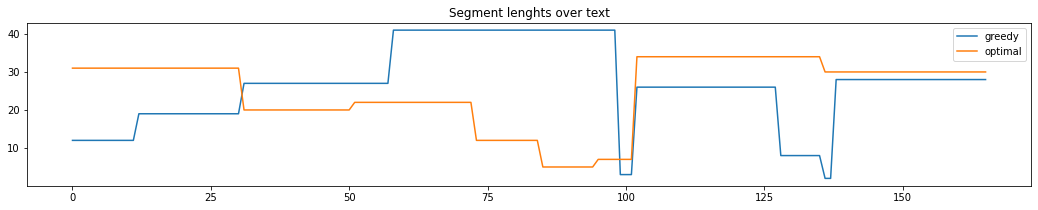

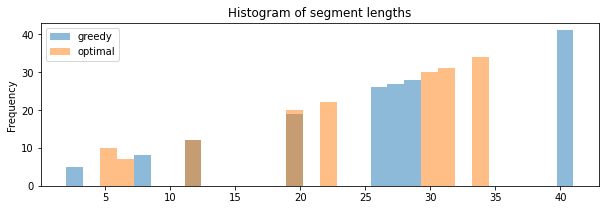

In [12]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [13]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

[" Even thinking about starting your podcast even obsessing about the idea for months and years ahead or you're overwhelmed by all the different technical stuff that goes into starting a podcast. ", "Well, and we're going to show you the four different ways. ", 'You can start your podcast this year. ', 'Hey, welcome to the Pod, sounds cool. ', "I'm Studio. ", "Steve, it weird podcast coaches podcast producers and we've helped dozens of clients and hundreds of students to get some really amazing results, their podcast, and we want to do the same for you and us video. ", "We're going to show you the four different ways. ", 'You can start your podcast from the very basic to a professional level. ', "And we're going to show you also the pros and cons of each option. ", 'By the end of this video. ', "You're going to know everything you need to know in order to start your podcast today. ", 'We are going to cover a lot in this video. ', 'So make sure you stick around until the end. ', 'And fo

In [14]:
print(sentenced_text)

[" Even thinking about starting your podcast even obsessing about the idea for months and years ahead or you're overwhelmed by all the different technical stuff that goes into starting a podcast. ", "Well, and we're going to show you the four different ways. ", 'You can start your podcast this year. ', 'Hey, welcome to the Pod, sounds cool. ', "I'm Studio. ", "Steve, it weird podcast coaches podcast producers and we've helped dozens of clients and hundreds of students to get some really amazing results, their podcast, and we want to do the same for you and us video. ", "We're going to show you the four different ways. ", 'You can start your podcast from the very basic to a professional level. ', "And we're going to show you also the pros and cons of each option. ", 'By the end of this video. ', "You're going to know everything you need to know in order to start your podcast today. ", 'We are going to cover a lot in this video. ', 'So make sure you stick around until the end. ', 'And fo

### 處理輸入

In [15]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [16]:
print(podcast_test)

[" Even thinking about starting your podcast even obsessing about the idea for months and years ahead or you're overwhelmed by all the different technical stuff that goes into starting a podcast. Well, and we're going to show you the four different ways. You can start your podcast this year. Hey, welcome to the Pod, sounds cool. I'm Studio. Steve, it weird podcast coaches podcast producers and we've helped dozens of clients and hundreds of students to get some really amazing results, their podcast, and we want to do the same for you and us video. We're going to show you the four different ways. You can start your podcast from the very basic to a professional level. And we're going to show you also the pros and cons of each option. By the end of this video. You're going to know everything you need to know in order to start your podcast today. We are going to cover a lot in this video. So make sure you stick around until the end. And for those of you who like to skip ahead, we left some 

# Headline generator

In [17]:
! pip install transformers datasets

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 325 kB 62.5 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 6.6 MB 42.4 MB/s 
     |████████████████████████████████| 77 kB 3.3 MB/s 
     |████████████████████████████████| 136 kB 45.4 MB/s 
     |████████████████████████████████| 212 kB 43.7 MB/s 
     |████████████████████████████████| 1.1 MB 11.9 MB/s 
     |████████████████████████████████| 127 kB 42.4 MB/s 
     |████████████████████████████████| 271 kB 42.0 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 144 kB 27.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.7 MB/s 


In [19]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [20]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [21]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [22]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [23]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'How to Start Your Podcast'}
<class 'dict'>
{'generated_text': 'Podcast Coaching - How to Start Your Podcast Today'}
<class 'dict'>
{'generated_text': 'Podcasting - How to Start Your Own Podcast'}
<class 'dict'>
{'generated_text': 'USB Microphones For Independent Podcasters'}
<class 'dict'>
{'generated_text': 'GarageBand Pro Tools vs GarageBand Pro Tools'}
<class 'dict'>
{'generated_text': 'Reaper - How to Record a Podcast'}
<class 'dict'>
{'generated_text': 'How to Edit a Podcast and Get Going in Reaper'}
<class 'dict'>
{'generated_text': 'Podcasting Tips - The Scarlett to I-20'}
<class 'dict'>
{'generated_text': 'Podcasting - The Ultimate Con'}
<class 'dict'>


In [24]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['How to Start Your Podcast']
['How to Start Your Podcast']
<class 'str'>
['Podcast Coaching', '-', 'How to Start Your Podcast Today']
['Podcast Coaching', '-', 'How to Start Your Podcast Today']
<class 'str'>
['Podcasting', '-', 'How to Start Your Own Podcast']
['Podcasting', '-', 'How to Start Your Own Podcast']
<class 'str'>
['USB Microphones For Independent Podcasters']
['USB Microphones For Independent Podcasters']
<class 'str'>
['GarageBand Pro Tools vs GarageBand Pro Tools']
['GarageBand Pro Tools vs GarageBand Pro Tools']
<class 'str'>
['Reaper', '-', 'How to Record a Podcast']
['Reaper', '-', 'How to Record a Podcast']
<class 'str'>
['How to Edit a Podcast and Get Going in Reaper']
['How to Edit a Podcast and Get Going in Reaper']
<class 'str'>
['Podcasting Tips', '-', 'The Scarlett to I', '-', '20']
['Podcasting Tips', '-', 'The Scarlett to I', ' ', '20']
<class 'str'>
['Podcasting', '-', 'The Ultimate Con']
['Podcasting', '-', 'The Ultimate Con']
<class 'str'>


In [25]:
for headline_string in headlines_string:
  print(headline_string)

 How to Start Your Podcast
 Podcast Coaching - How to Start Your Podcast Today
 Podcasting - How to Start Your Own Podcast
 USB Microphones For Independent Podcasters
 GarageBand Pro Tools vs GarageBand Pro Tools
 Reaper - How to Record a Podcast
 How to Edit a Podcast and Get Going in Reaper
 Podcasting Tips - The Scarlett to I 20
 Podcasting - The Ultimate Con


In [26]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [27]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 749 kB 54.5 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [29]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
print(len(result_nltk))
print(result_nltk)

9
["Even thinking starting podcast even obsessing idea months years ahead 're overwhelmed different technical stuff goes starting podcast . Well , 're going show four different ways . You start podcast year . Hey , welcome Pod , sounds cool . I 'm Studio . Steve , weird podcast coaches podcast producers 've helped dozens clients hundreds students get really amazing results , podcast , want us video . We 're going show four different ways . You start podcast basic professional level . And 're going show also pros cons option . By end video . You 're going know everything need know order start podcast today . We going cover lot video . So make sure stick around end . And like skip ahead , left time stamps description topics covering different ways create podcast thing works . How get audio files phones ? Or computers , way Google podcasts . Apple podcasts Spotify podcasting . Is podcast directories like Apple , Google Spotify . They n't actually hold MP3 file . Actually need upload MP3 f

In [31]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
print(len(feature_name_nltk))
print(feature_name_nltk)

527
['20', '40', '60', 'able', 'accessories', 'accuser', 'actually', 'add', 'addition', 'adjust', 'advanced', 'affordable', 'ahead', 'all', 'allow', 'allows', 'already', 'also', 'alw', 'amazing', 'among', 'anchor', 'and', 'android', 'app', 'apple', 'apps', 'area', 'around', 'art', 'artwork', 'atr2100', 'audacity', 'audience', 'audio', 'automatically', 'bad', 'basic', 'beautiful', 'because', 'becoming', 'beginning', 'bells', 'best', 'better', 'big', 'bit', 'blast', 'bored', 'both', 'break', 'bring', 'bs', 'budget', 'budgets', 'bunch', 'but', 'by', 'cable', 'call', 'called', 'camera', 'cameras', 'causes', 'challenged', 'channel', 'cheap', 'cheaper', 'check', 'choice', 'choose', 'chose', 'chosen', 'classic', 'clear', 'client', 'clients', 'club', 'coaches', 'com', 'come', 'comes', 'coming', 'complex', 'complicated', 'compression', 'computer', 'computers', 'con', 'confident', 'cons', 'content', 'control', 'cool', 'could', 'cover', 'covering', 'crank', 'create', 'creativity', 'cut', 'cute', 

In [33]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

In [34]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
7
20   0.05571378162230826
adjust   0.05571378162230826
allows   0.047056746947920544
also   0.026115184571334556
and   0.07080124124413797
audio   0.12274344929046423
break   0.05571378162230826
budget   0.05571378162230826
budgets   0.05571378162230826
cable   0.16714134486692478
call   0.047056746947920544
cheap   0.05571378162230826
cheaper   0.05571378162230826
choose   0.05571378162230826
chose   0.05571378162230826
chosen   0.05571378162230826
classic   0.11142756324461651
complicated   0.05571378162230826
computer   0.0322574484224337
crank   0.05571378162230826
dynamic   0.05571378162230826
end   0.08182896619364281
even   0.0322574484224337
ever   0.05571378162230826
expensive   0.047056746947920544
first   0.0322574484224337
focus   0.05571378162230826
focusrite   0.11142756324461651
for   0.05571378162230826
gain   0.05571378162230826
game   0.05571378162230826
get   0.026115184571334556
goes   0.047056746947920544
going   0.11800206874

In [35]:
print(keyword_segment)
print(tfidf_segment)

['20', 'adjust', 'allows', 'also', 'and', 'audio', 'break', 'budget', 'budgets', 'cable', 'call', 'cheap', 'cheaper', 'choose', 'chose', 'chosen', 'classic', 'complicated', 'computer', 'crank', 'dynamic', 'end', 'even', 'ever', 'expensive', 'first', 'focus', 'focusrite', 'for', 'gain', 'game', 'get', 'goes', 'going', 'good', 'high', 'if', 'illustration', 'input', 'inputs', 'interface', 'interfaces', 'intimidated', 'into', 'is', 'knob', 'know', 'like', 'liked', 'll', 'many', 'microphone', 'microphones', 'much', 'need', 'needs', 'next', 'not', 'now', 'number', 'once', 'one', 'option', 'output', 'people', 'picks', 'place', 'plug', 'podcast', 'podcasters', 'podcasting', 'pretty', 'professional', 'put', 'ranging', 're', 'really', 'recommendations', 'record', 'right', 'scarlet', 'scarlett', 'see', 'shield', 'shirt', 'simply', 'single', 'sm58', 'sm70', 'so', 'sound', 'start', 'that', 'there', 'thing', 'this', 'time', 'tons', 'top', 'two', 'us', 'usb', 'use', 'used', 'using', 'usually', 've', 

In [36]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

In [37]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

[]
0
0


## 篩選出名詞和形容詞

In [38]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [39]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [40]:
select_word

[]

## 去掉sponsor

In [41]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [42]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num-1)>=i): is_sponsor.append(sentenced_text[j-num-1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

In [43]:
for sent in is_sponsor: 
  print(sent)

In [44]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

 Even thinking about starting your podcast even obsessing about the idea for months and years ahead or you're overwhelmed by all the different technical stuff that goes into starting a podcast. 
Well, and we're going to show you the four different ways. 
You can start your podcast this year. 
Hey, welcome to the Pod, sounds cool. 
I'm Studio. 
Steve, it weird podcast coaches podcast producers and we've helped dozens of clients and hundreds of students to get some really amazing results, their podcast, and we want to do the same for you and us video. 
We're going to show you the four different ways. 
You can start your podcast from the very basic to a professional level. 
And we're going to show you also the pros and cons of each option. 
By the end of this video. 
You're going to know everything you need to know in order to start your podcast today. 
We are going to cover a lot in this video. 
So make sure you stick around until the end. 
And for those of you who like to skip ahead, we

# 重新來分段一次

penalty 43.46
166 sentences, 6 segments, avg 27.67 sentences per segment
optimal score 4687.22, greedy score 4670.18
[4687.217306351976, 4670.179503553744]
(4687.217306351976, 4670.179503553744)
ratio of scores 1.0036


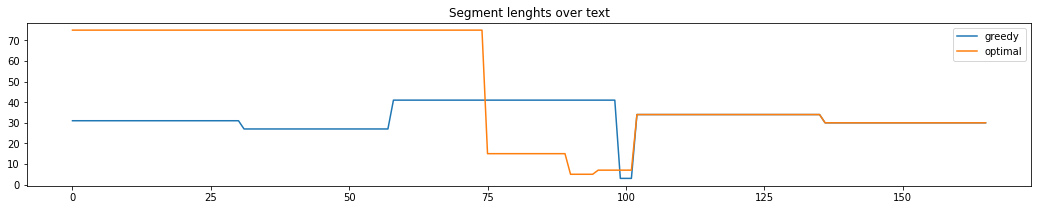

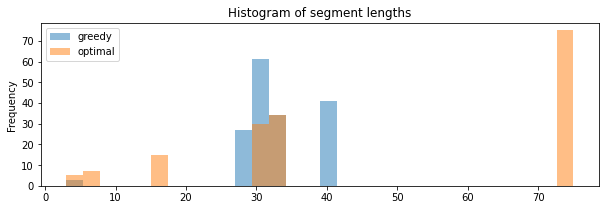

In [45]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [46]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

[" Even thinking about starting your podcast even obsessing about the idea for months and years ahead or you're overwhelmed by all the different technical stuff that goes into starting a podcast. ", "Well, and we're going to show you the four different ways. ", 'You can start your podcast this year. ', 'Hey, welcome to the Pod, sounds cool. ', "I'm Studio. ", "Steve, it weird podcast coaches podcast producers and we've helped dozens of clients and hundreds of students to get some really amazing results, their podcast, and we want to do the same for you and us video. ", "We're going to show you the four different ways. ", 'You can start your podcast from the very basic to a professional level. ', "And we're going to show you also the pros and cons of each option. ", 'By the end of this video. ', "You're going to know everything you need to know in order to start your podcast today. ", 'We are going to cover a lot in this video. ', 'So make sure you stick around until the end. ', 'And fo

In [47]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [48]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [49]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'Podcasting - How to Start Your Own Podcast'}
{'generated_text': 'USB Microphones - The Best USB Microphones For Podcasting'}
{'generated_text': 'Reaper - How to Record a Podcast'}
{'generated_text': 'How to Edit a Podcast and Get Going in Reaper'}
{'generated_text': 'Podcasting Tips - The Scarlett to I-20'}
{'generated_text': 'Podcasting - The Ultimate Con'}


In [50]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['Podcasting', '-', 'How to Start Your Own Podcast']
['Podcasting', '-', 'How to Start Your Own Podcast']
<class 'str'>
['USB Microphones', '-', 'The Best USB Microphones For Podcasting']
['USB Microphones', '-', 'The Best USB Microphones For Podcasting']
<class 'str'>
['Reaper', '-', 'How to Record a Podcast']
['Reaper', '-', 'How to Record a Podcast']
<class 'str'>
['How to Edit a Podcast and Get Going in Reaper']
['How to Edit a Podcast and Get Going in Reaper']
<class 'str'>
['Podcasting Tips', '-', 'The Scarlett to I', '-', '20']
['Podcasting Tips', '-', 'The Scarlett to I', ' ', '20']
<class 'str'>
['Podcasting', '-', 'The Ultimate Con']
['Podcasting', '-', 'The Ultimate Con']
<class 'str'>


In [51]:
for headline_string in headlines_string:
  print(headline_string)

 Podcasting - How to Start Your Own Podcast
 USB Microphones - The Best USB Microphones For Podcasting
 Reaper - How to Record a Podcast
 How to Edit a Podcast and Get Going in Reaper
 Podcasting Tips - The Scarlett to I 20
 Podcasting - The Ultimate Con
